In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

In [2]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import networkx as nx

In [3]:
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [5]:
#%matplotlib notebook

In [6]:
data, cluster_id = sklearn.datasets.make_blobs(n_samples = 20, n_features = 3, random_state=1, cluster_std=3)

In [7]:
umap_object = umap.UMAP(n_neighbors=5, min_dist=.25).fit(data)

In [8]:
points = umap_object.embedding_

In [9]:
# create dataframe of edges
coo_graph = umap_object.graph_.tocoo()
edge_df = pd.DataFrame(
        np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
        columns=("source", "target", "weight"),
    )
edge_df["source"] = edge_df.source.astype(np.int32)
edge_df["target"] = edge_df.target.astype(np.int32)

In [10]:
edge_df[:3]

,source,target,weight
0,0,1,0.569978
1,0,9,0.397779
2,0,18,0.606066


In [11]:
# get estimate of initial spectral embedding
network_graph = nx.Graph()
network_graph.add_weighted_edges_from([(row.source, row.target, row.weight) for idx, row in edge_df.iterrows()])
spectral_embedding = list(pd.DataFrame(nx.spectral_layout(network_graph)).T.sort_index().values)

In [12]:
# create a random intitial embedding for visualization purposes
random_embedding = np.random.rand(np.shape(points)[0], np.shape(points)[1])

In [13]:
# creata dataframe of points and embeddings
point_df = pd.DataFrame()
point_df['data_'] = list(data)
point_df['embedding'] = list(points)
point_df['label'] = list(cluster_id)
point_df['spectral_embedding'] = list(spectral_embedding)
point_df['random_embedding'] = list(random_embedding)

In [14]:
point_df[:3]

,data_,embedding,label,spectral_embedding,random_embedding
0,"[-0.05812716910083182, 4.13056997182554, -4.25...","[-5.1321635, -1.648608]",0,"[0.5911517811478506, -0.008832536128889757]","[0.7598645748077808, 0.5587611808785558]"
1,"[-3.359090593844753, 6.596416658084696, -8.878...","[-4.148205, -1.999342]",0,"[0.9150689049483262, -0.08201851022513977]","[0.21553099946336596, 0.9542193431513741]"
2,"[-7.067464840991654, -10.093321663983687, -11....","[-6.7417245, 3.251735]",1,"[-0.5792991372167784, -0.7744489820127733]","[0.19781747219333268, 0.9634653698036789]"


In [15]:
point_df.to_pickle('point_df.pickle')

In [16]:
edge_df.to_pickle('edge_df.pickle')

In [17]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [18]:
import seaborn as sns

In [19]:
pal = sns.color_palette('Dark2', 3)
custommap = ListedColormap([
    list(pal[0])+[1],
    list(pal[1])+[1],
    list(pal[2])+[1],
], name='custommap')

In [20]:
from tfumap.paths import FIGURE_DIR, ensure_dir, save_fig

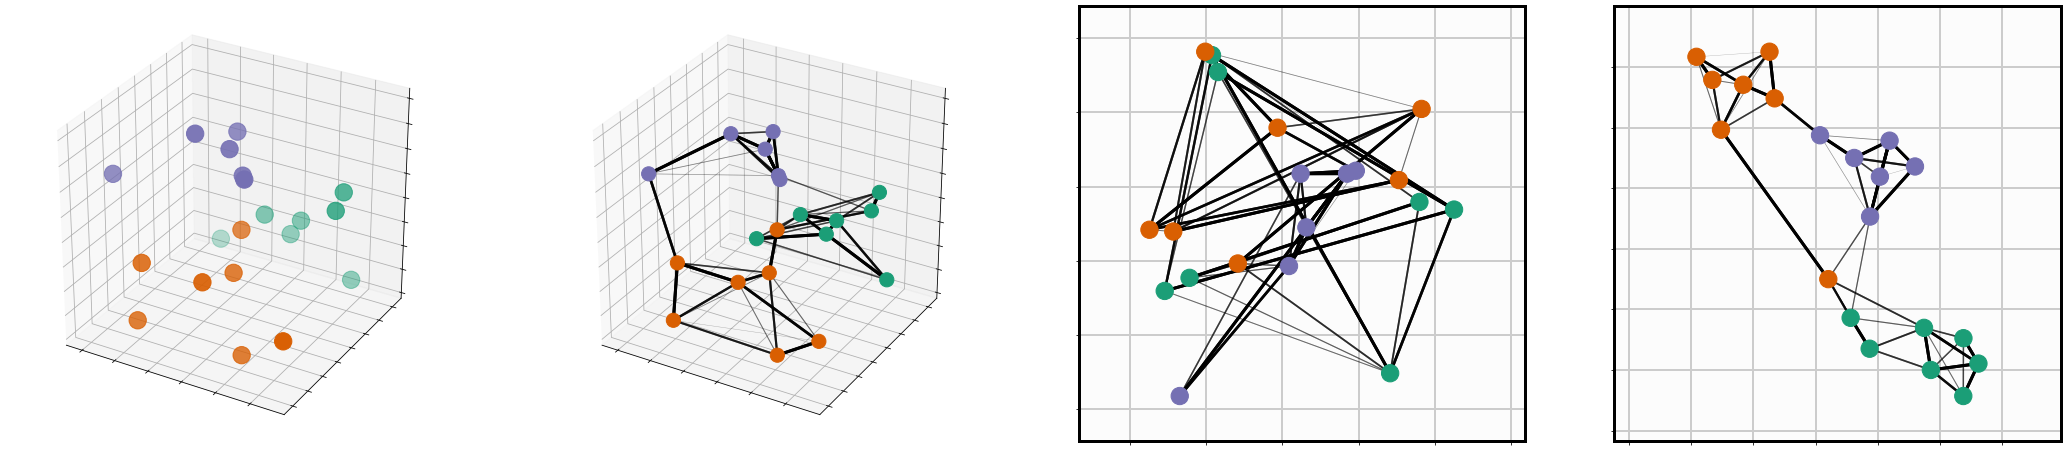

In [21]:
node_size = 300
cmap = custommap # plt.cm.tab20c# plt.cm.brg # plt.cm.Dark2
ncols = 4
zm = 8
padding = 0.05

fig = plt.figure(figsize=(ncols*zm*1.15,zm))

# Initial data
ax1 = fig.add_subplot(1,ncols,1, projection='3d')
ax1.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=node_size)
ax1.set_xticklabels([]); ax1.set_yticklabels([]); ax1.set_zticklabels([]);


### Graph on 3d
ax2  = fig.add_subplot(1,ncols,2, projection='3d')
for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].data_
    ed = point_df.iloc[int(row.target)].data_
    ax2.plot([st[0], ed[0]], [st[1], ed[1]], [st[2], ed[2]], alpha = row.weight, color= 'k', lw=row.weight*3)
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=200, alpha = 1.0)


### Graph on 2D
ax3  = fig.add_subplot(1,ncols,3)
ax3.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)


for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].random_embedding
    ed = point_df.iloc[int(row.target)].random_embedding
    ax3.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=1)
ax3.set_xticklabels([]); ax3.set_yticklabels([]);


ax3.scatter(random_embedding[:,0], random_embedding[:,1], c=cluster_id, cmap = cmap, s=node_size, zorder = 100)

ymin, ymax = ax3.get_ylim()
xmin, xmax = ax3.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
if np.diff(new_xlim) > np.diff(new_ylim):
    new_ylim = [
        new_ylim[0] - (np.diff(new_xlim) - np.diff(new_ylim)) /2,
        new_ylim[1] + (np.diff(new_xlim) - np.diff(new_ylim)) /2
               ]
elif np.diff(new_xlim) < np.diff(new_ylim):
    new_xlim = [
        new_xlim[0] - (np.diff(new_ylim) - np.diff(new_xlim)) /2,
        new_xlim[1] + (np.diff(new_ylim) - np.diff(new_xlim)) /2
               ]
ax3.set_ylim(new_ylim)
ax3.set_xlim(new_xlim)
[i.set_linewidth(3) for i in ax3.spines.values()]
ax3.set_facecolor((0,0,0,0.01))
ax3.set_axisbelow(True)


### Graph on 2D
ax4  = fig.add_subplot(1,ncols,4)
ax4.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)

for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].embedding
    ed = point_df.iloc[int(row.target)].embedding
    ax4.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=1)
ax4.set_xticklabels([]); ax4.set_yticklabels([]);

ax4.scatter(points[:,0], points[:,1], c=cluster_id, cmap = cmap, s=node_size, zorder = 100)


ymin, ymax = ax4.get_ylim()
xmin, xmax = ax4.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
if np.diff(new_xlim) > np.diff(new_ylim):
    new_ylim = [
        new_ylim[0] - (np.diff(new_xlim) - np.diff(new_ylim)) /2,
        new_ylim[1] + (np.diff(new_xlim) - np.diff(new_ylim)) /2
               ]
elif np.diff(new_xlim) < np.diff(new_ylim):
    new_xlim = [
        new_xlim[0] - (np.diff(new_ylim) - np.diff(new_xlim)) /2,
        new_xlim[1] + (np.diff(new_ylim) - np.diff(new_xlim)) /2
               ]
ax4.set_ylim(new_ylim)
ax4.set_xlim(new_xlim)
[i.set_linewidth(3) for i in ax4.spines.values()]
#ax4.axis('off')
ax4.set_facecolor((0,0,0,0.01))
ax4.set_axisbelow(True)

#ax4.margins(0.5)

ensure_dir(FIGURE_DIR / 'UMAP_example')
save_fig(FIGURE_DIR / 'UMAP_example' / 'dim_reduction2', save_png=True, dpi=300, save_jpg=True, save_pdf=True)

plt.show()

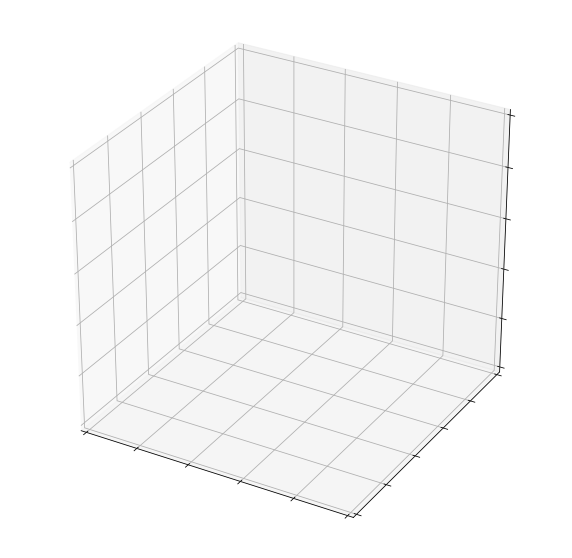

In [22]:
fig = plt.figure(figsize=(10,10))

ax  = fig.add_subplot(1,1,1, projection='3d')
ax.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);


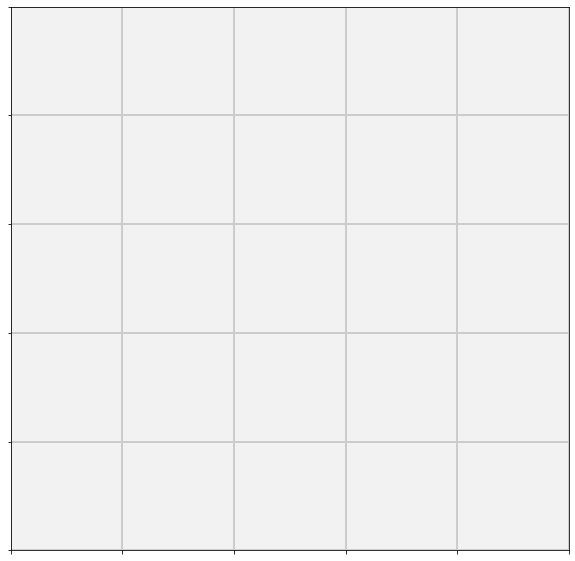

In [23]:
fig = plt.figure(figsize=(10,10))

ax  = fig.add_subplot(1,1,1,)
ax.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_facecolor((0,0,0,0.05))


### Draw network

In [38]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=True, facecolor = '#EEEEEE', edgecolor='#333333', linewidth=5)
        pyplot.gca().add_patch(circle)


class Layer:
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 2
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in np.arange(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return (
            self.horizontal_distance_between_neurons
            * (self.number_of_neurons_in_widest_layer - number_of_neurons)
            / 2
        )

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        lw = .5 + (np.random.rand(1)-.5)#/3
        line = pyplot.Line2D(
            (neuron1.x - x_adjustment, neuron2.x + x_adjustment),
            (neuron1.y - y_adjustment, neuron2.y + y_adjustment),
            linewidth = lw*10,
            alpha = lw,
            color="black",
            
        )
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw(self.neuron_radius)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = (
            self.number_of_neurons_in_widest_layer
            * self.horizontal_distance_between_neurons
        )


class NeuralNetwork:
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

In [39]:
neural_network = [3,4,4, 2]
widest_layer = max( neural_network )
network = NeuralNetwork( widest_layer )
for l in neural_network:
    network.add_layer(l)

'/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/figures/UMAP_example/network_trained'

TypeError: unhashable type: 'numpy.ndarray'

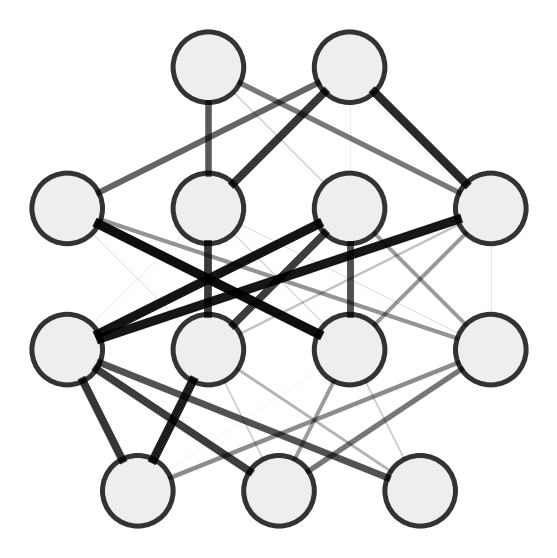

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
for layeri, layer in enumerate(network.layers):
    layer = network.layers[layeri]
    if layeri == len(network.layers)-1:
        layeri = -1
    layer.draw(layeri)
ax.axis('scaled')
ax.axis('off')


ensure_dir(FIGURE_DIR / 'UMAP_example')
plt.savefig(str(FIGURE_DIR / 'UMAP_example' / 'network_trained') + ".pdf", dpi=300, bbox_inches="tight", pad_inches=0)